# Distinctiveness with species

This experiment involves distinctiveness classification using degree 2 and degree 3 polynomial SVCs on feature maps generated from pywhaleid, using animal species as an additional feature. The performance of each model will be compared.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from time import time
import numpy as np

/var/folders/4b/f86rqqqj3rg8vczy4jw34t6r0000gn/T/ipykernel_79990/562681109.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# get features and labels
data = pd.read_pickle('pifsc_embeddings2.pickle')
features = dict(data)
data = pd.read_pickle('pifsc_embeddings.pkl')
features.update(data)

cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [3]:
# clean labels
is_na = labels.distinctiveness.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
# labels.reset_index(drop=False, inplace=True)

# clean features
imgs = labels.image.tolist()
features = {k: v for k, v in features.items() if k in imgs}
assert len(features) == len(labels)

In [4]:
# get data, split
Y = labels.distinctiveness
X = np.array([features[i] for i in labels.image])
species = labels.species.astype('category').cat.codes
X = np.insert(X, 0, species, axis=1)
# sc = StandardScaler()
# X = sc.fit_transform(X)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [5]:
# train Logistic regression
classifiers = [SVC(class_weight='balanced', random_state=42, kernel='poly', degree=2),
               SVC(class_weight='balanced', random_state=42, kernel='poly')]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for clf in classifiers:
#     clf.fit(X_train, Y_train)

In [6]:
preds = []
for clf in classifiers:
    pred = cross_val_predict(clf, X, Y, n_jobs=-1, cv=cv)
    preds.append(pred)
    print(f'deg={clf.degree}'.center(53, '-'))
    print(classification_report(Y, pred))

------------------------deg=2------------------------
              precision    recall  f1-score   support

         1.0       0.75      0.74      0.74      1152
         2.0       0.92      0.78      0.84      2343
         3.0       0.55      0.14      0.22        44
         4.0       0.08      1.00      0.15        37

    accuracy                           0.76      3576
   macro avg       0.58      0.66      0.49      3576
weighted avg       0.85      0.76      0.80      3576

------------------------deg=3------------------------
              precision    recall  f1-score   support

         1.0       0.76      0.76      0.76      1152
         2.0       0.93      0.78      0.85      2343
         3.0       0.00      0.00      0.00        44
         4.0       0.08      1.00      0.15        37

    accuracy                           0.77      3576
   macro avg       0.44      0.64      0.44      3576
weighted avg       0.86      0.77      0.80      3576



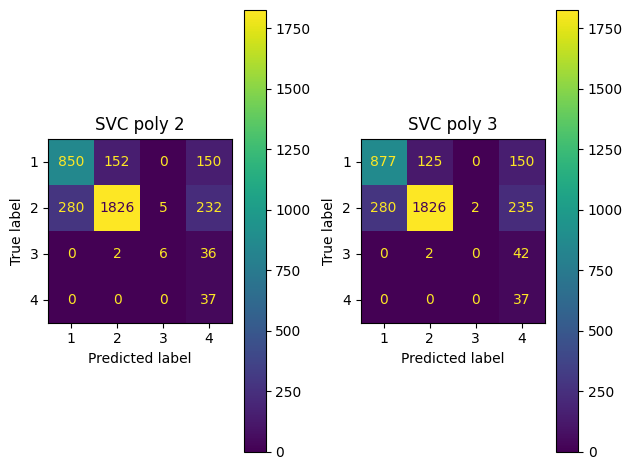

In [7]:
# results
fig, axes = plt.subplots(1, 2)
for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):
    cm = confusion_matrix(Y, preds[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4])
    disp.plot(ax=ax)
    ax.title.set_text(f'{type(clf).__name__} {clf.kernel} {clf.degree}')
plt.tight_layout()

In [8]:
print(Y.value_counts())

distinctiveness
2.0    2343
1.0    1152
3.0      44
4.0      37
Name: count, dtype: int64
